# Analyze results of kraken2 origin database against metagenomes
Connected notebook: kraken2_classification_analysis.ipynb describes how the database was created, which genomes were included and commands for running the metagenomes

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
#Load data (don't forget to remove global sewage negative controls!)
df=pd.read_csv('/storage/stefan/new_origins_august23/metagenomes/metagenome_results/abundance_all_metagenomes.csv', sep='\t')
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17244 entries, 0 to 17243
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sample_acc          17244 non-null  object
 1   n_reads             17244 non-null  int64 
 2   n_classified_reads  17244 non-null  int64 
 3   source              17244 non-null  object
 4   source_class        17244 non-null  object
 5   n_bacterial_reads   17244 non-null  int64 
 6   species             17244 non-null  object
 7   n_origin_reads      17244 non-null  int64 
 8   sample_loc          17244 non-null  object
 9   project             17244 non-null  object
dtypes: int64(4), object(6)
memory usage: 1.3+ MB


In [66]:
#Get accessions for global sewage negative controls and remove them from the df
'/storage/shared/metagenomes/global_sewage/metadata/global_sewage_metadata.csv'
negatives=[l.split(';')[-2] for l in open('/storage/shared/metagenomes/global_sewage/metadata/global_sewage_metadata.csv', 'r') if 'Negative control' in l]

df.drop(df[df['sample_acc'].isin(negatives)==True].index, axis=0, inplace=True)

In [67]:
#Also remove all samples (3) that have less than 100000 reads overall
df.drop(df[df['n_reads']<100000].index, axis=0, inplace=True)

#And remove samples that contain less than 5000 bacterial reads
df.drop(df[df['n_bacterial_reads']<50000].index, axis=0, inplace=True)

#One pig and pultry sample & one salt marsh sample have weird metadata, fix here
df['source'].replace('ERX2294126 Bulgaria','pig faeces', inplace=True)
df['sample_loc'].replace('host-associated', 'Bulgaria', inplace=True)
df['sample_loc'].replace('sediment', 'United Kingdom', inplace=True)

#Also standardize writing of faeces/feces
df['source'].replace('pig faeces', 'pig feces', inplace=True)
df['source'].replace('poultry faeces', 'poultry feces', inplace=True)
df['source'].replace('feces', 'human feces', inplace=True)

#Rename 'wastewater metagenome' to 'wastewater'
df['source'].replace('wastewater metagenome', 'Wastewater', inplace=True)

#Capitalize some categories
df['source'].replace('pig feces', 'Pig feces', inplace=True)
df['source'].replace('human feces', 'Human feces', inplace=True)
df['source'].replace('poultry feces', 'Poultry feces', inplace=True)

#Replace source class 'Animal' with Animal feces
df['source_class'].replace('Animal', 'Animal feces', inplace=True)

In [68]:
#assign sampling locations to their respective continents
conts={'Europe':['Austria','Sweden', 'Latvia', 'France', 'United Kingdom', 'Hungary', 'Croatia', 'Spain', 'Germany', 'Czech Republic', 'Iceland', 'Greece', 'Portugal', 'Slovenia', 'Malta', 'Belgium', 'Italy', 'Switzerland', 'Bosnia and Herzegovina', 'Slovakia', 'Finland', 'Montenegro', 'Serbia', 'Denmark', 'Greenland', 'Netherlands', 'Poland', 'Bulgaria', 'Norway', 'Macedonia'], \
        'North America':['USA', 'Canada', 'North America', 'North America/Canada'], \
       'Middle East':['Israel', 'Saudi Arabia', 'Turkey', 'United Arab Emirates', 'Kuwait', 'Benin'],\
        'Africa':['South Africa', 'Chad', 'Madagascar', 'Tanzania', "Cote d'Ivoire", 'Uruguay', 'Uganda', 'Mauritius', 'Botswana', 'Ghana', 'Nigeria', 'Senegal', 'Morocco', 'Mozambique', 'Cameroon', 'Togo', 'Democratic Republic of the Congo', 'Burkina Faso', 'Kenya'],\
        'Asia':['Malaysia', 'Thailand', 'Japan', 'India', 'South Korea', 'Cambodia', 'Taiwan', 'China', 'Pakistan', 'Bangladesh', 'Nepal', 'Singapore', 'Viet Nam'],\
        'Oceania':['Australia', 'New Zealand'],\
        'Central/South America':['Guatemala', 'Brazil', 'Bolivia', 'Chile', 'Barbados', 'Argentina', 'Colombia', 'Ecuador', 'Saint Lucia', 'Paraguay']}

def assign_cont(x, conts):
    
    for k, v in conts.items():
        cont=False
        if x['sample_loc'] in v:
            cont=True
            return k
    if cont==False:
        return 'Unknown'         

df['sample_loc2']=df.apply(lambda x: assign_cont(x, conts), axis=1)

#Create a column containing information on both sample source and continental location
def new_col(x):
    return f"{x['source']} ({x['sample_loc2']})"

df['source_cont']=df.apply(lambda x: new_col(x), axis=1)
df['source_cont'].unique()

array(['Human feces (Unknown)', 'Wastewater (Europe)',
       'Wastewater (Africa)', 'Wastewater (Middle East)',
       'Wastewater (Central/South America)', 'Wastewater (North America)',
       'Wastewater (Asia)', 'Wastewater (Oceania)', 'Pig feces (Europe)',
       'Poultry feces (Europe)', 'Cow feces (North America)',
       'Freshwater/sediment (North America)',
       'Forest soil (North America)', 'Aquaculture (Asia)',
       'Freshwater/sediment (Asia)', 'Freshwater/sediment (Europe)',
       'Salt water/Sediment (Europe)', 'Agricultural soil (Europe)',
       'Ocean water (Unknown)', 'Polluted river water (Asia)',
       'Desert rock (North America)'], dtype=object)

In [69]:
#Replace Freshwater/Sediment Asia with antibiotic-polluted freshwater, same for polluted river water
df['source_cont'].replace('Freshwater/sediment (Asia)', 'Antibiotic-polluted lake (Asia)', inplace=True)
df['source_cont'].replace('Polluted river water (Asia)', 'Antibiotic-polluted river (Asia)', inplace=True)
print(df['source_cont'].unique())

['Human feces (Unknown)' 'Wastewater (Europe)' 'Wastewater (Africa)'
 'Wastewater (Middle East)' 'Wastewater (Central/South America)'
 'Wastewater (North America)' 'Wastewater (Asia)' 'Wastewater (Oceania)'
 'Pig feces (Europe)' 'Poultry feces (Europe)' 'Cow feces (North America)'
 'Freshwater/sediment (North America)' 'Forest soil (North America)'
 'Aquaculture (Asia)' 'Antibiotic-polluted lake (Asia)'
 'Freshwater/sediment (Europe)' 'Salt water/Sediment (Europe)'
 'Agricultural soil (Europe)' 'Ocean water (Unknown)'
 'Antibiotic-polluted river (Asia)' 'Desert rock (North America)']


In [70]:
#Replace source class for the affected rows
df['source_class']=df.apply(lambda x: 'Antibiotic-polluted freshwater' if 'Antibiotic-polluted' in x['source_cont'] else x['source_class'], axis=1)

In [71]:
print(df['source_class'].unique())

['Human feces' 'Wastewater' 'Animal feces' 'Freshwater' 'Soil'
 'Saltwater/Animal' 'Antibiotic-polluted freshwater' 'Saltwater']


In [72]:
#Check number of unique samples in dataframe --> This is because we have 9 rows for every sample of course :)
print(len(df['sample_acc']), len(df['sample_acc'].unique()))

15795 1697


Now normalize abundances by number of bacterial reads in sample *1 Miliion to get abundance/million reads. Do the same for the total amount of reads!

In [73]:
#df['abundance_bact_per_millionr']=df['n_origin_reads']/(df['n_bacterial_reads']/1000000)
#df['abundance_per_millionr']=df['n_origin_reads']/(df['n_reads']/1000000)

df['abundance_bact_per_millionr']=df['n_origin_reads']/df['n_bacterial_reads']
df['abundance_per_millionr']=df['n_origin_reads']/df['n_reads']

In [74]:
len(df['source_class'].unique())

8

In [75]:
df['source_class'].value_counts()/9 # Divided by 9 because each of th e9 origin species has its own rowper sample

source_class
Human feces                       538.0
Animal feces                      390.0
Wastewater                        273.0
Saltwater                         249.0
Soil                              176.0
Antibiotic-polluted freshwater     63.0
Freshwater                         53.0
Saltwater/Animal                   13.0
Name: count, dtype: float64

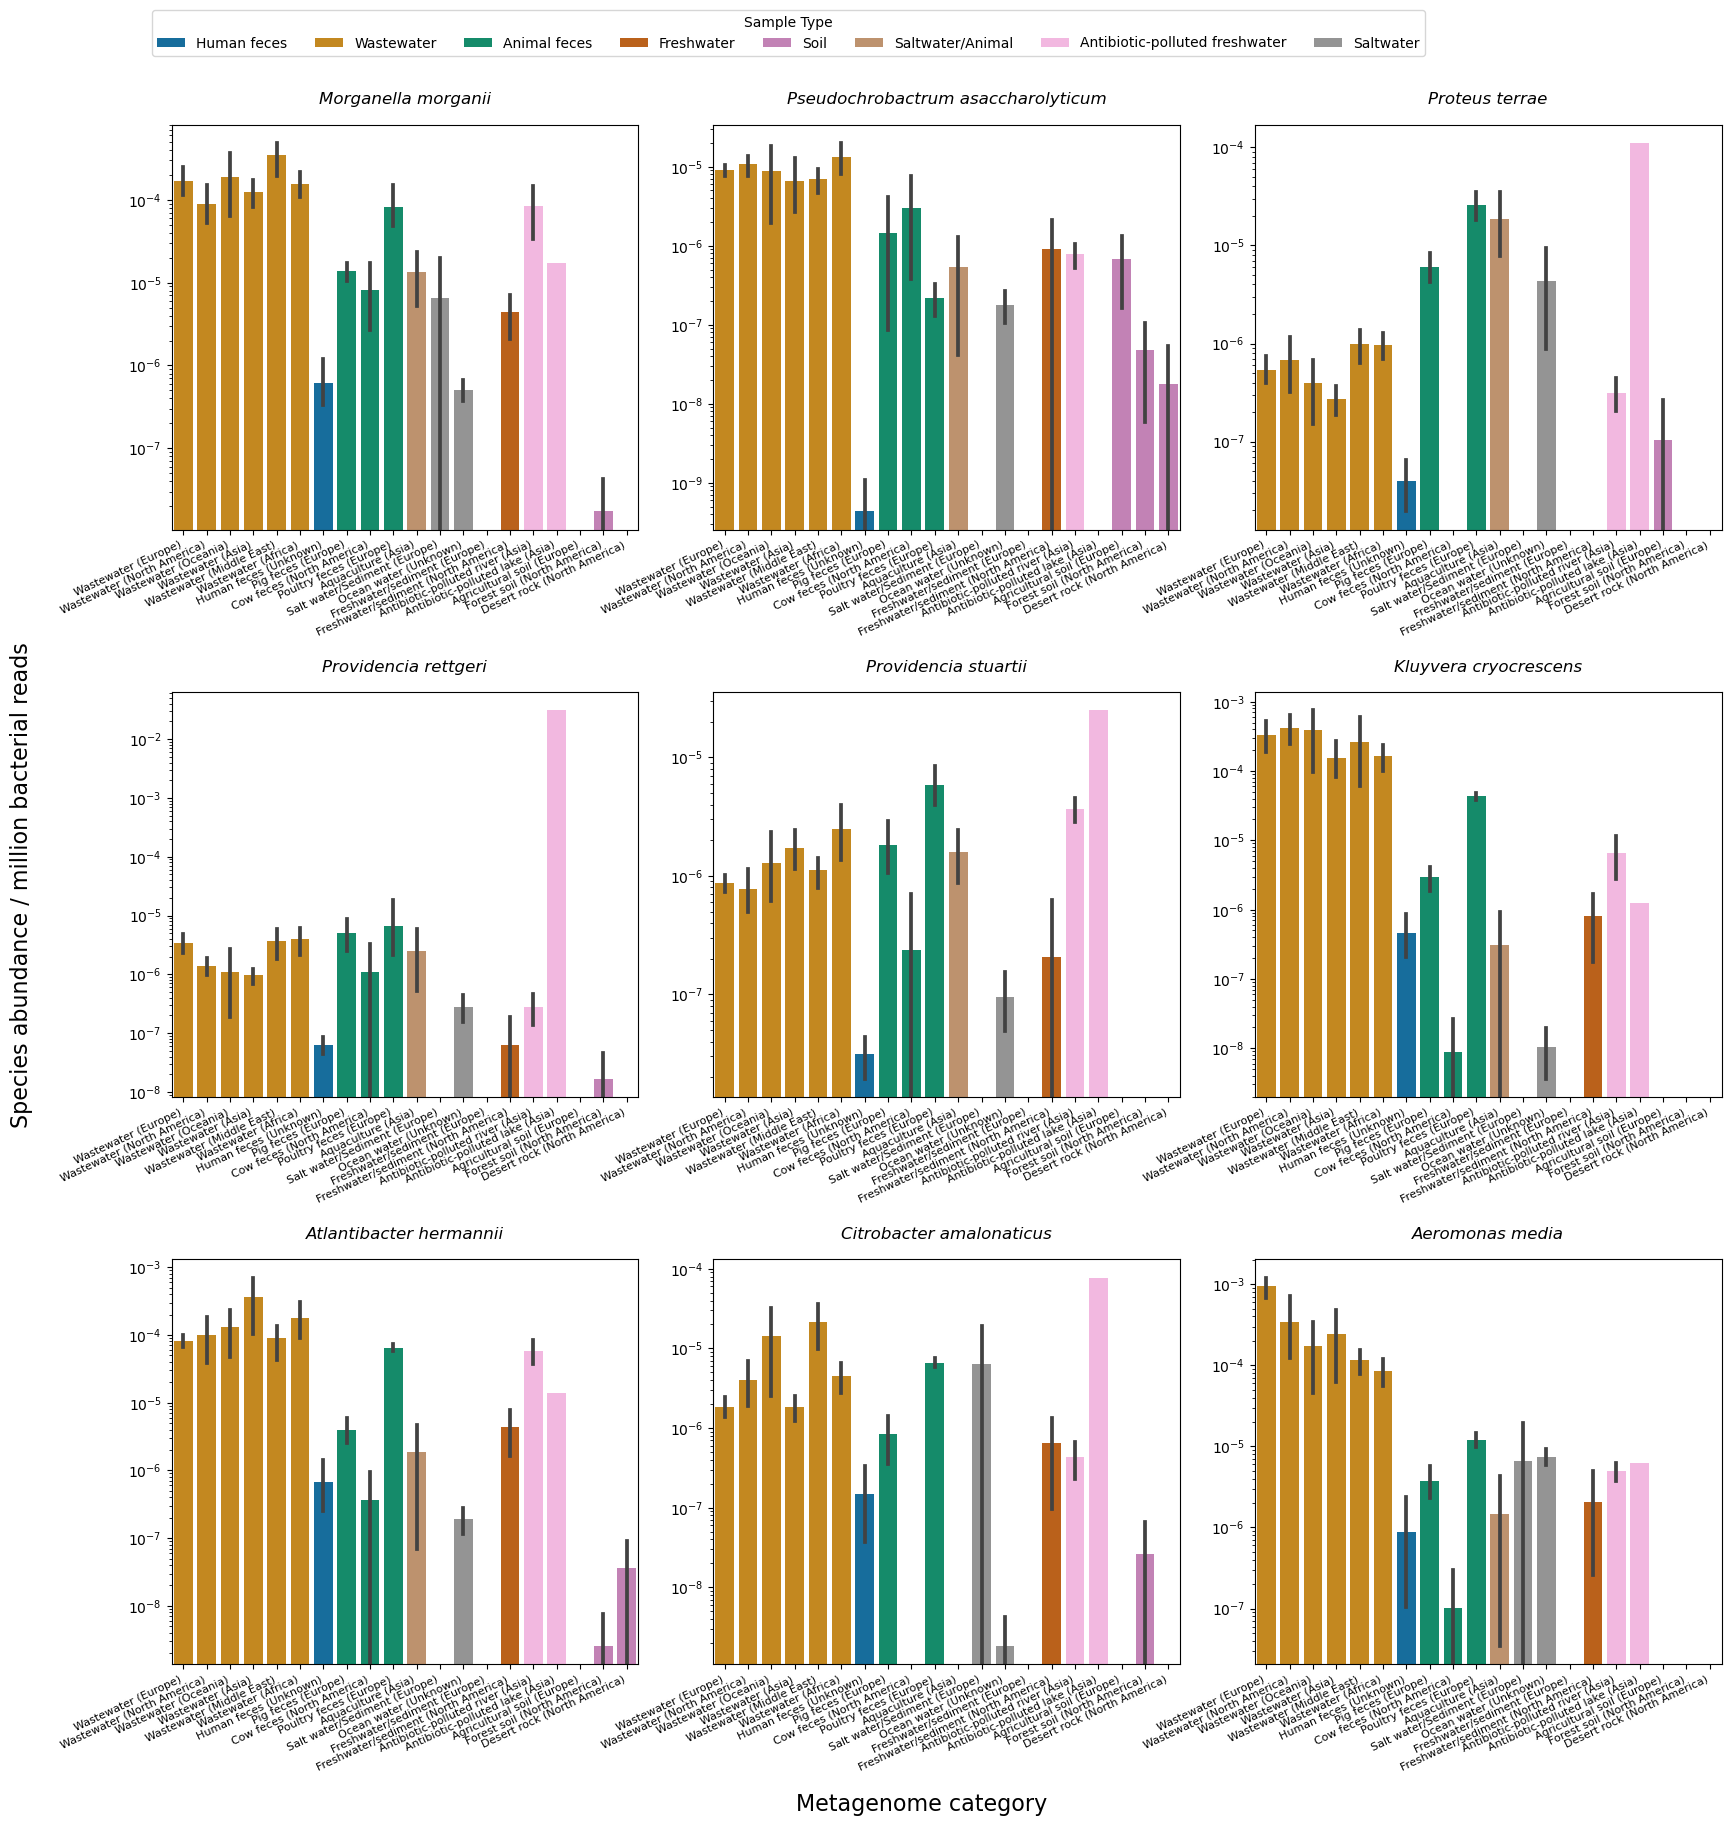

In [76]:
#For each origin species, plot the abundances
fig, axes = plt.subplots(3, 3, figsize=[20, 20])
fig.subplots_adjust(hspace=0.4, wspace=0.16)


for i, (ax, s) in enumerate(zip(axes.flatten(), df['species'].unique())):

    plt_df=df[df['species']==s]

    p=sns.barplot(x=plt_df['source_cont'], y=plt_df['abundance_bact_per_millionr'], ax=ax, \
        order=['Wastewater (Europe)', 'Wastewater (North America)', 'Wastewater (Oceania)', 'Wastewater (Asia)', 'Wastewater (Middle East)', 'Wastewater (Africa)', \
            'Human feces (Unknown)', 'Pig feces (Europe)', 'Cow feces (North America)', 'Poultry feces (Europe)', 'Aquaculture (Asia)', 'Salt water/Sediment (Europe)','Ocean water (Unknown)', \
            'Freshwater/sediment (Europe)','Freshwater/sediment (North America)','Antibiotic-polluted river (Asia)', 'Antibiotic-polluted lake (Asia)', 'Agricultural soil (Europe)',\
            'Forest soil (North America)', 'Desert rock (North America)'], hue=plt_df['source_class'], dodge=False, palette='colorblind')
    p.set_xlabel('')
    p.set_ylabel('')

    #Set logarithmic scale in order to display kazipally lake and the other samples together
    p.set_yscale('log')
    p.set_title(f'{s}', y=1.03, fontsize=12, style='italic')
    p.set_xticklabels(p.get_xticklabels(), rotation=25, ha='right', fontsize=8)
    
    if i==0:
        ax.legend(loc='upper right', bbox_to_anchor=(2.7, 1.3), ncol=len(plt_df['source_class'].unique()), title='Sample Type')
    else:
        ax.get_legend().remove()

fig.text(0.5, 0.04, 'Metagenome category', ha='center', va='center', fontsize=16)
fig.text(0.05, 0.5, 'Species abundance / million bacterial reads', ha='center', va='center', rotation=90, fontsize=16)

fig.savefig('metagenome_abundances_ylog.svg', format='svg')

plt.show()

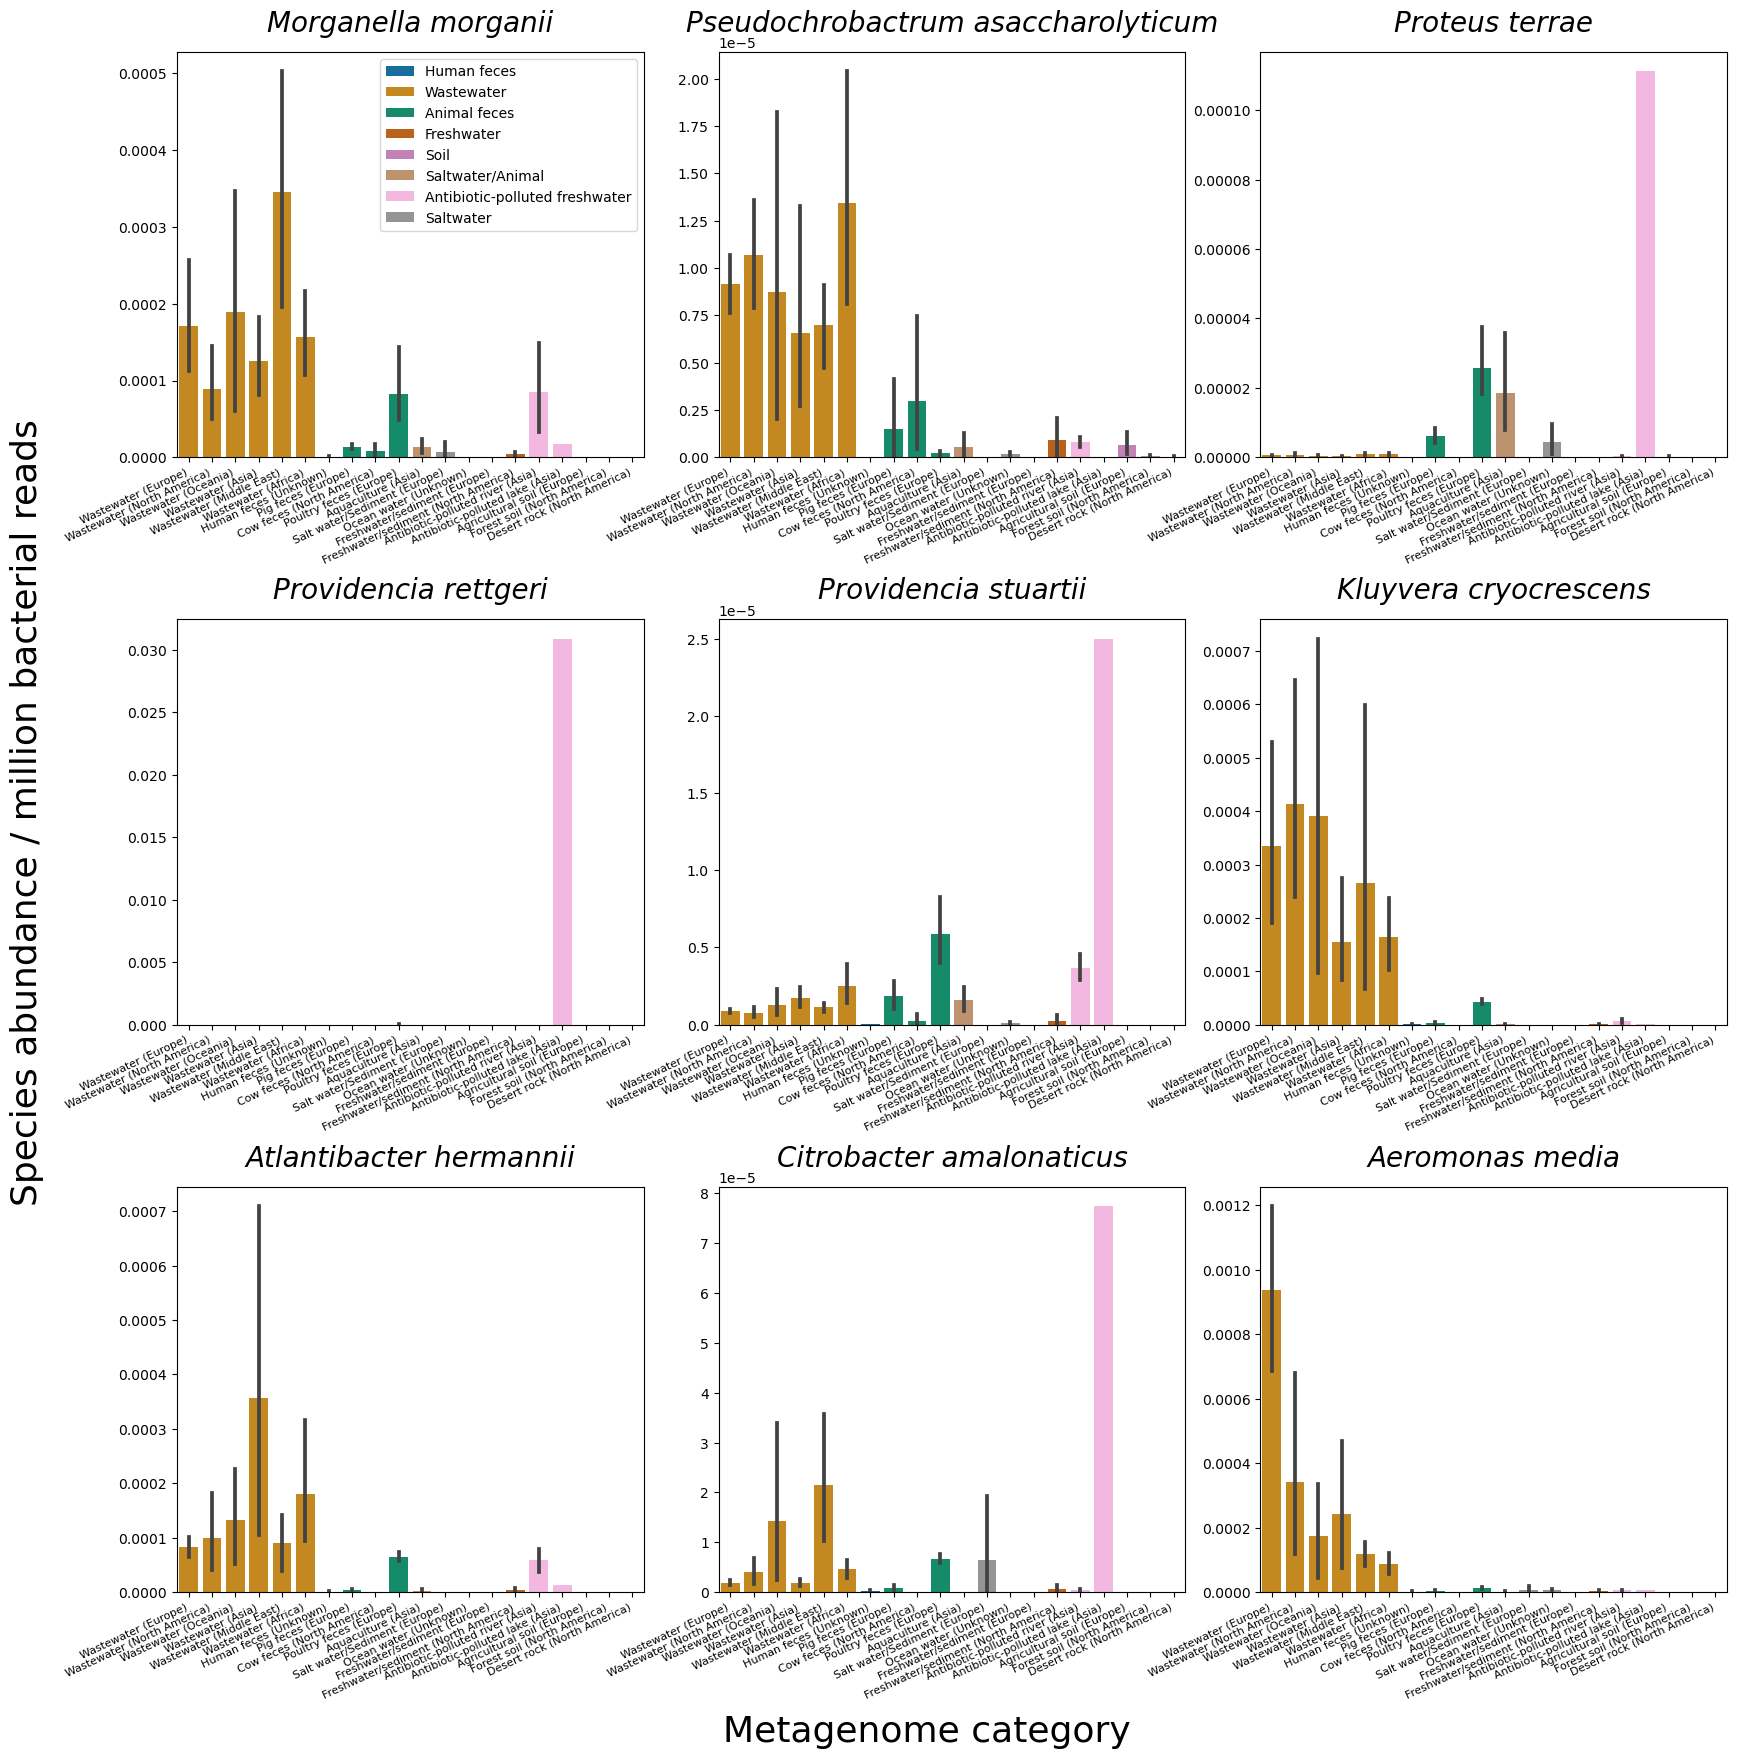

In [77]:
#For each origin species, plot the abundances
fig, axes = plt.subplots(3, 3, figsize=[20, 20])
fig.subplots_adjust(hspace=0.4, wspace=0.16)

df_dr=df.copy(deep=True)
df_dr.drop(df_dr[df_dr['source_cont']=='Freshwater/sediment (Asia)'].index, inplace=True)

for i, (ax, s) in enumerate(zip(axes.flatten(), df['species'].unique())):

    plt_df=df_dr[df_dr['species']==s]

    p=sns.barplot(x=plt_df['source_cont'], y=plt_df['abundance_bact_per_millionr'], ax=ax, \
        order=['Wastewater (Europe)', 'Wastewater (North America)', 'Wastewater (Oceania)', 'Wastewater (Asia)', 'Wastewater (Middle East)', 'Wastewater (Africa)', \
            'Human feces (Unknown)', 'Pig feces (Europe)', 'Cow feces (North America)', 'Poultry feces (Europe)', 'Aquaculture (Asia)', 'Salt water/Sediment (Europe)','Ocean water (Unknown)', \
            'Freshwater/sediment (Europe)','Freshwater/sediment (North America)','Antibiotic-polluted river (Asia)', 'Antibiotic-polluted lake (Asia)', 'Agricultural soil (Europe)',\
            'Forest soil (North America)', 'Desert rock (North America)'], hue=plt_df['source_class'], dodge=False, palette='colorblind')
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_title(f'{s}', y=1.03, fontsize=20, style='italic')
    p.set_xticklabels(p.get_xticklabels(), rotation=25, ha='right', fontsize=8)
    
    if i==0:
        ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()



fig.text(0.5, 0.04, 'Metagenome category', ha='center', va='center', fontsize=26)
fig.text(0.05, 0.5, 'Species abundance / million bacterial reads', ha='center', va='center', rotation=90, fontsize=26)

fig.savefig('metagenome_abundances.svg', format='svg')

plt.show()

For the publications, we'll do the following figures: One like the ones above showing average relative abundances for each species, one heatmap with fraction of samples in which each species was detected (Fig. 1 in Fannys paper)



In [78]:
len(df[df['source_cont']=='Freshwater/sediment (Asia)']['sample_acc'].unique())

0

In [79]:
df['n_bacterial_reads'].min()

50355

In [80]:
#Before creating a heatmap, the data need to be rarefied!

def rarefy(x): # where x represents a line in the dataframe --> function needs >15 mins to finish
    
    rng=np.random.default_rng()
    x=rng.choice([1]*x['n_origin_reads']+[0]*(x['n_bacterial_reads']-x['n_origin_reads']), df['n_bacterial_reads'].min(), replace=False)
    return np.sum(x)

#In this function, draw x times from a binomial distribution, where the probability of success is 
#the proportion of origin reads to bacterial reads --> finishes in 0.7 seconds :) #BUT binomial distribution is WITH replacement, we need WITHOUT replacement!
#This might be a case for the hypergeometric distribution
def rarefy_bin(x):

    rng=np.random.default_rng()
    x=rng.binomial(n=df['n_bacterial_reads'].min(), p=x['n_origin_reads']/x['n_bacterial_reads'], size=100)
    return x[0]

def rarefy_hypergeo(x):

    rng=np.random.default_rng()
    x=rng.hypergeometric(x['n_origin_reads'], x['n_bacterial_reads']-x['n_origin_reads'], df['n_bacterial_reads'].min(), 1000)
    return np.mean(x)

df['n_origin_reads_rarefied']=df.apply(lambda x: rarefy_hypergeo(x), axis=1)


In [90]:
hm_dict={}

spec_list=[s for s in df['species'].unique()]
env_list=['Wastewater (Europe)', 'Wastewater (North America)', 'Wastewater (Oceania)', 'Wastewater (Asia)', 'Wastewater (Middle East)', 'Wastewater (Africa)', \
            'Human feces (Unknown)', 'Pig feces (Europe)', 'Cow feces (North America)', 'Poultry feces (Europe)', 'Aquaculture (Asia)', 'Salt water/Sediment (Europe)','Ocean water (Unknown)', \
            'Freshwater/sediment (Europe)','Freshwater/sediment (North America)','Antibiotic-polluted river (Asia)', 'Antibiotic-polluted lake (Asia)', 'Agricultural soil (Europe)',\
            'Forest soil (North America)', 'Desert rock (North America)']

prop_dict={}

prop_dict['Species']=[]
for s in spec_list:
    prop_dict['Species'].append(s)

    for env in env_list:

        #Exclude environments with <3 samples from analysis
        if len(df[df['source_cont']==env])/9<3:
            pass

        else:

            if not env in prop_dict:
                prop_dict[env]=[]
                
            #subset dataframe to just contain one species & one environment
            df2=df[(df['species']==s) & (df['source_cont']==env)]

            #calculate fraction of samples that have >= reads for each environment/species combination
            prop=len(df2[df2['n_origin_reads_rarefied']>=1])/len(df2)

            prop_dict[env].append(float(f'{prop:.2f}'))


prop_df=pd.DataFrame.from_dict(prop_dict)


In [91]:
df['source_cont'].value_counts()/9

source_cont
Human feces (Unknown)                  538.0
Ocean water (Unknown)                  246.0
Pig feces (Europe)                     200.0
Poultry feces (Europe)                 177.0
Forest soil (North America)            134.0
Wastewater (Europe)                    103.0
Antibiotic-polluted river (Asia)        62.0
Wastewater (Africa)                     62.0
Freshwater/sediment (North America)     52.0
Wastewater (Asia)                       48.0
Desert rock (North America)             24.0
Wastewater (Central/South America)      23.0
Wastewater (North America)              19.0
Agricultural soil (Europe)              18.0
Aquaculture (Asia)                      13.0
Cow feces (North America)               13.0
Wastewater (Middle East)                10.0
Wastewater (Oceania)                     8.0
Salt water/Sediment (Europe)             3.0
Freshwater/sediment (Europe)             1.0
Antibiotic-polluted lake (Asia)          1.0
Name: count, dtype: float64

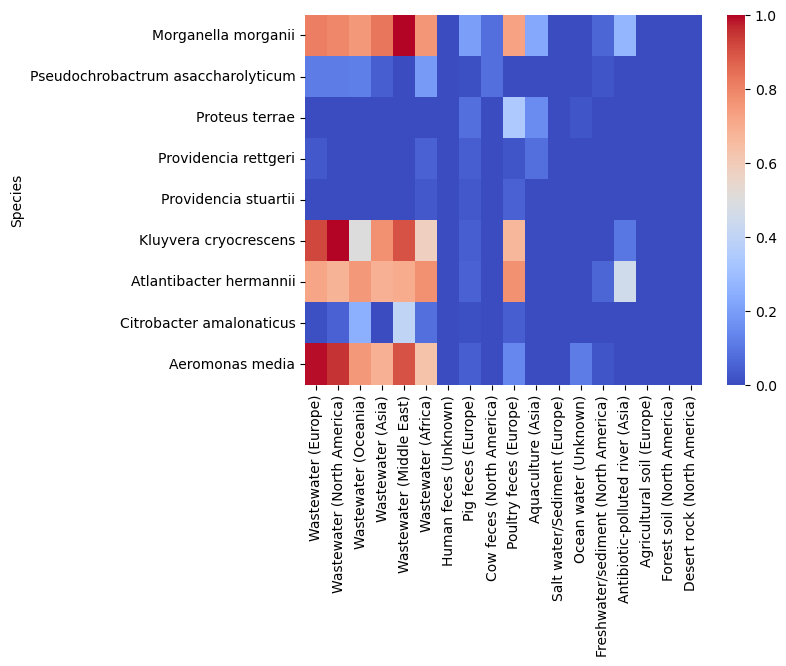

In [92]:
sns.heatmap(prop_df.set_index('Species'), cmap='coolwarm', annot=False)
plt.savefig('metagenome_heatmap.png', format='png', dpi=1200, transparent=True, bbox_inches='tight')


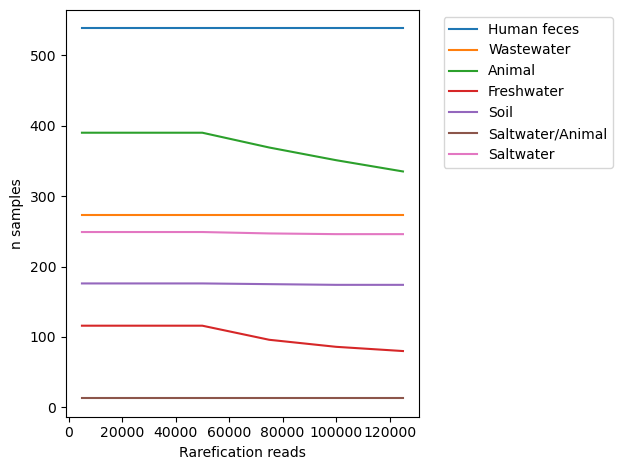

In [17]:
#The values in th eabove figue are very sensitive to the rarefication size -lets see how many samples we have based on the rarefication value
rvalues=[5000, 10000, 25000, 50000, 75000, 100000, 125000]

for env in df['source_class'].unique():

    df_env=df[df['source_class']==env]
    lens=[len(df_env[df_env['n_bacterial_reads']>r])/9 for r in rvalues]
    plt.plot(rvalues, lens, label=env)
    plt.xlabel('Rarefication reads')
    plt.ylabel('n samples')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
plt.show()

The above plot suggests that 50000 might be a reasonable value for the number of reads to rarefy.

In [18]:
#Check which source classes we have right now
df['source'].unique()

array(['Human feces', 'Wastewater', 'Pig feces', 'Poultry feces',
       'Cow feces', 'Freshwater/sediment', 'Forest soil', 'Aquaculture',
       'Salt water/Sediment', 'Agricultural soil', 'Ocean water',
       'Polluted river water', 'Desert rock'], dtype=object)